In this notebook we will automatically generate a set of evaluation questions based on wandb docs

In [1]:
import random
import wandb
import re
import openai
import os
from tqdm.auto import tqdm
import time

from langchain.docstore.document import Document

import time
from typing import Any, Dict, List

import json
import wandb
from wandb.sdk.lib.runid import generate_id
from wandb.integration.langchain import WandbTracer

from langchain import LLMChain
from langchain.chains import HypotheticalDocumentEmbedder, RetrievalQAWithSourcesChain
from langchain.chat_models import ChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate
)
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain.vectorstores.base import VectorStoreRetriever
from langchain.chains import HypotheticalDocumentEmbedder, RetrievalQAWithSourcesChain
from langchain.callbacks import get_openai_callback

In [2]:
# !git clone https://github.com/wandb/docodile.git

In [3]:
# !pip install "langchain>=0.0.175" "wandb>=0.15.3" openai cohere tqdm fastcore

In [4]:
PROJECT = "wandbot_synth" 
ENTITY = "wandbot"

In [5]:
import openai
from getpass import getpass

def get_openai_key():
  if os.getenv("OPENAI_API_KEY") is None:
    if any(['VSCODE' in x for x in os.environ.keys()]):
      print('Please enter password in the VS Code prompt at the top of your VS Code window!')
    os.environ["OPENAI_API_KEY"] = getpass("Paste your OpenAI key from: https://platform.openai.com/account/api-keys\n")
    openai.api_key = os.getenv("OPENAI_API_KEY")
  assert os.getenv("OPENAI_API_KEY", "").startswith("sk-"), "This doesn't look like a valid OpenAI API key"
  print("OpenAI API key configured")

get_openai_key()

Please enter password in the VS Code prompt at the top of your VS Code window!
OpenAI API key configured


# Answer Questions with WandBot

In [7]:
class VectorStoreRetrieverWithScore(VectorStoreRetriever):
    def get_relevant_documents(self, query: str) -> List[Document]:
        if self.search_type == "similarity":
            docs_and_scores = self.vectorstore.similarity_search_with_score(
                query, **self.search_kwargs
            )
            docs = []
            for doc, score in docs_and_scores:
                doc.metadata["score"] = score
                docs.append(doc)
        elif self.search_type == "mmr":
            docs = self.vectorstore.max_marginal_relevance_search(
                query, **self.search_kwargs
            )
        else:
            raise ValueError(f"search_type of {self.search_type} not allowed.")
        return docs


class FAISSWithScore(FAISS):
    def as_retriever(self) -> VectorStoreRetrieverWithScore:
        return VectorStoreRetrieverWithScore(
            vectorstore=self,
            search_type="similarity",
            search_kwargs={"k": 10},
        )


class RetrievalQAWithSourcesChainWithScore(RetrievalQAWithSourcesChain):
    reduce_k_below_max_tokens: bool = True
    max_tokens_limit: int = 2816

    def _get_docs(self, inputs: Dict[str, Any]) -> List[Document]:
        question = inputs[self.question_key]
        docs = self.retriever.get_relevant_documents(question)
        return self._reduce_tokens_below_limit(docs)


def load_artifacts(config):
    faiss_artifact = wandb.use_artifact(config.faiss_artifact, type="search_index")
    faiss_artifact_dir = faiss_artifact.download()

    hyde_prompt_artifact = wandb.use_artifact(
        config.hyde_prompt_artifact, type="prompt"
    )
    hyde_artifact_dir = hyde_prompt_artifact.download()
    hyde_prompt_file = f"{hyde_artifact_dir}/hyde_prompt.txt"

    chat_prompt_artifact = wandb.use_artifact(
        config.chat_prompt_artifact, type="prompt"
    )
    chat_artifact_dir = chat_prompt_artifact.download()
    chat_prompt_file = f"{chat_artifact_dir}/chat_prompt.txt"

    return {
        "faiss": faiss_artifact_dir,
        "hyde_prompt": hyde_prompt_file,
        "chat_prompt": chat_prompt_file,
    }


In [8]:
import json 
def parse_source_documents(source_documents):
    source_docs_dict = {}
    for i,source_doc in enumerate(source_documents):
        source_docs_dict[f"source_doc_{i}"] ={
            "page_content":source_doc.page_content,
            "metadata":source_doc.metadata["source"],
            "lookup_index":source_doc.lookup_index,
            "lookup_str":source_doc.lookup_str,
            }   

    return json.dumps(source_docs_dict)

In [9]:
# qa_chain.json

In [ ]:
from types import SimpleNamespace

# login to openai with your api key
get_openai_key()

wandbot_config = SimpleNamespace(
    faiss_artifact="parambharat/wandb_docs_bot/faiss_store:latest",
    hyde_prompt_artifact="parambharat/wandb_docs_bot/hyde_prompt:latest",
    chat_prompt_artifact="parambharat/wandb_docs_bot/system_prompt:latest",
    model_name="gpt-3.5-turbo",
    eval_model = "gpt-3.5-turbo", #'command-nightly',
    temperature=0,
    hyde_llm_temperature=0.3,
    openai_eval_llm_temperature=0.0,
    command_llm_temperature=0.0,
    cohere_generate_cost_usd = 0.0000025  # cost per characters (not tokens), $0.0025 per generation unit (1000 chars)
)

wandb.init(
        name="synth_answer_generation_final",
        project=PROJECT,
        entity=ENTITY,
        config=wandbot_config,
        )

artifacts = load_artifacts(wandb.config)

### Prompts

Load wandbot v1 prompts

In [11]:
# LOAD DATA AND PROMPTS FROM ARTIFACTS
faiss_dir = artifacts["faiss"]
hyde_prompt_template =  open(artifacts["hyde_prompt"]).read()
wandbot_v1_system_prompt_template = open(artifacts["chat_prompt"]).read()
human_message_prompt_template = "{question}"


# SETUP Hypothetical Document Embedder (HyDE)
hyde_messages = [
    SystemMessagePromptTemplate.from_template(hyde_prompt_template),
    HumanMessagePromptTemplate.from_template("{question}"),
]
hyde_prompt = ChatPromptTemplate.from_messages(hyde_messages)

### Alternative System Prompts

Create alternate wandbot prompts to test

In [12]:
system_prompts = {}

system_prompts["wandbot_v1_few_shot"] = wandbot_v1_system_prompt_template

system_prompts["wandbot_v1_zero_shot"]= """
As an AI assistant for the open source library wandb, your task is to answer questions based on 
the given extracted parts of a long document and the question. You can provide a conversational 
answer with a hyperlink to the documentation only if it is explicitly listed as a source in the context. 

Provide a code block directly from the documentation wherever possible. If you do not know the answer, 
you can say "Hmm, I'm not sure." If the question is not related to wandb or Weights & Biases, politely 
inform the user that you can only answer questions related to wandb. The documentation for wandb can be
found at https://docs.wandb.ai.

Begin:
================

Question: {question}
================
{summaries}
================
Final Answer in Markdown:
"""

system_prompts["default_langchain_qa"]= """
Use the following pieces of context to answer the question at the end. If you don't know the answer, 
just say that you don't know, don't try to make up an answer.

{summaries}

Question: {question}
Helpful Answer:
"""

Get prompt token counts

In [13]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4")
jj = enc.encode("hello world")
len(jj)

for k in system_prompts.keys():
    print(f"{k} token count: {len(enc.encode(system_prompts[k]))}")

wandbot_v1_few_shot token count: 660
wandbot_v1_zero_shot token count: 165
default_langchain_qa token count: 54


### Evaluation Propmt

OpenAI Evaluation Prompt

In [14]:
openai_eval_system_prompt = """As an experienced software quality assurance tester, you are evaluating the quality of the response (WANDBOT_RESPONSE) from a
Weights & Biasses (aka wandb, W&B) support bot called `wandbot`. Weights & Biasses is a machine learning ops (MLOps) python library and app.
Supporting documentation (SUPPORTING_DOCUMENTATION) is provided to help you assess the quality of the response. You job is to grade (GRADE) the response.

Grade the following WANDBOT_RESPONSE given the USER_QUESTION and SUPPORTING_DOCUMENTATION. 
Grade the WANDBOT_RESPONSE based ONLY on its factual accuracy. It is OK if the WANDBOT_RESPONSE contains more information than in SUPPORTING_DOCUMENTATION, as long as it does not contain any conflicting statements.
Your GRADE should only be POSITIVE or NEGATIVE to indicate whether the WANDBOT_RESPONSE is accurate or not given the SUPPORTING_DOCUMENTATION.
If WANDBOT_RESPONSE says that there is no specific information provided in the context or that it doesn't know, then the GRADE is NEGATIVE.
Be sure to read the SUPPORTING_DOCUMENTATION carefully before grading the WANDBOT_RESPONSE and be highlighly critical of the WANDBOT_RESPONSE.
Only respond with POSITIVE or NEGATIVE for GRADE. 
In GRADE_JUSTIFICATION, explain why your GRADE of WANDBOT_RESPONSE is POSITIVE or NEGATIVE. Use one or two sentences maximum. Keep the GRADE_JUSTIFICATION as concise as possible.
Remember, you are only grading the WANDBOT_RESPONSE. The SUPPORTING_DOCUMENTATION is only provided to help you grade the WANDBOT_RESPONSE.

This is the format of the input USER_QUESTION, WANDBOT_RESPONSE and SUPPORTING_DOCUMENTATION that you will be given as well as the format of the GRADE_JUSTIFICATION and GRADE that you will provide:


USER_QUESTION: user question here
WANDBOT_RESPONSE: the response from the `wandbot` support bot here
SUPPORTING_DOCUMENTATION: retrieved documentation from the wandb docs here


GRADE_JUSTIFICATION: justification for the GRADE here, keep it concise, 1 or 2 sentences only
GRADE: POSITIVE or NEGATIVE here


Remember, start your reponse with "GRADE_JUSTIFICATION". You must also ways provide a "GRADE". Begin!
"""

"Remember, you are only grading the WANDBOT_RESPONSE. The SUPPORTING_DOCUMENTATION is only provided to help you grade the WANDBOT_RESPONSE." 
- neagtive grade based on what was in supporting docs, even though response was correct

"You must always provide both a GRADE_JUSTIFICATION and a GRADE" - missing GRADE

"Remember, start your reponse with "GRADE_JUSTIFICATION". You must also ways provide a "GRADE"." and added "GRADE_JUSTIFICATION:" to the end of the human template - it started to reply with "USER_QUESTION:..." etc

In [15]:
example_human = """

USER_QUESTION: How do I create a wandb sweep?
WANDBOT_RESPONSE: To create a W&B Articfact, you can use the wandb.Artifact class like so ```artifact = wandb.Artifact(name='bicycle-dataset', type='dataset')```
SUPPORTING_DOCUMENTATION: '{{"source_doc_0": {{"page_content": "Use Weights & Biases Sweeps to automate hyperparameter search and explore the space of possible models. Create a sweep with a few lines of code.", "metadata": "https://docs.wandb.ai/guide", "lookup_index": 0, "lookup_str": ""}}}}'

"""

example_assistant = """
GRADE_JUSTIFICATION: The USER_QUESTION was about how to create a wandb sweep, but the WANDBOT_RESPONSE answers how to create a wandb artifact. Therefore the WANDBOT_RESPONSE is not accurate and I will give a negative grade.
GRADE: NEGATIVE

"""

eval_human_message_prompt_template = """

USER_QUESTION: {question}
WANDBOT_RESPONSE: {answer}
SUPPORTING_DOCUMENTATION: {source_documents}.


GRADE_JUSTIFICATION:"""

In [16]:
eval_messages = [
    SystemMessagePromptTemplate.from_template(openai_eval_system_prompt),
    HumanMessagePromptTemplate.from_template(example_human, additional_kwargs={"name": "example_user"}),
    AIMessagePromptTemplate.from_template(example_assistant, additional_kwargs={"name": "example_assistant"}),
    HumanMessagePromptTemplate.from_template(eval_human_message_prompt_template)
]
eval_prompt = ChatPromptTemplate.from_messages(eval_messages)

### Load Embeddings and Vector Store

In [20]:
base_embeddings = OpenAIEmbeddings()
embeddings = HypotheticalDocumentEmbedder(
    llm_chain=LLMChain(llm=ChatOpenAI(
        temperature=wandb.config.hyde_llm_temperature), 
        prompt=hyde_prompt),
    base_embeddings=base_embeddings,
    verbose=False
)

# LOAD FAISS VECTOR STORE
vector_store = FAISSWithScore.load_local(faiss_dir, embeddings)

In [21]:
# LOAD QA CHAINS FOR EACH SYSTEM PROMPT
def load_qa_chain(system_prompt_template, vector_store=vector_store, chain_type="stuff"):
    qa_messages = [
        SystemMessagePromptTemplate.from_template(system_prompt_template, input_variables=["context", "question"]),
        HumanMessagePromptTemplate.from_template(human_message_prompt_template),
    ]   
    qa_prompt = ChatPromptTemplate.from_messages(qa_messages)

    llm = ChatOpenAI(
        model_name=wandb.config.model_name,
        temperature=wandb.config.temperature,
        request_timeout=120
        )

    qa_chain = RetrievalQAWithSourcesChainWithScore.from_chain_type(
        llm = llm,
        chain_type=chain_type,
        retriever=vector_store.as_retriever(),
        chain_type_kwargs={"prompt": qa_prompt},
        return_source_documents=True,
        verbose=False
    )
    return qa_chain


Create timestamps

In [22]:
import pandas as pd
import numpy as np

def generate_timestamps(n=10000, start_date='2023-03-01', end_date='2023-05-31'):
    # Range of datetimes with 1-minute intervals
    rng = pd.date_range(start_date, end_date, freq='S')

    # Create weights for all datetimes
    weights = pd.Series(1, index=rng)

    # Decrease weights for weekends
    weights[rng.to_series().dt.dayofweek > 4] *= 0.5

    # Decrease weight for Easter Sunday (2023-04-09)
    easter = pd.to_datetime('2023-04-09')
    weights[rng.to_series().between(easter, easter + pd.DateOffset(days=1))] *= 0.5
    easter_monday = pd.to_datetime('2023-04-10')
    weights[rng.to_series().between(easter_monday, easter_monday + pd.DateOffset(days=1))] *= 0.5

    # Increase weights for 8am-6pm on weekdays
    mask = ((rng.to_series().dt.hour >= 8) & (rng.to_series().dt.hour <= 18) & (rng.to_series().dt.dayofweek <= 4))
    weights[mask] *= 1.2

    # Increase weights for Tuesday, Wednesday, Thursday
    mask = ((rng.to_series().dt.dayofweek >= 1) & (rng.to_series().dt.dayofweek <= 3))
    weights[mask] *= 1.5

    # Normalize weights
    weights /= weights.sum()

    # Sample 10000 datetimes using weights
    sampled_datetimes = np.random.choice(rng, size=n, p=weights)

    # Sort the datetimes
    sampled_datetimes.sort()

    return sampled_datetimes

timestamps = generate_timestamps()
len(timestamps)

10000

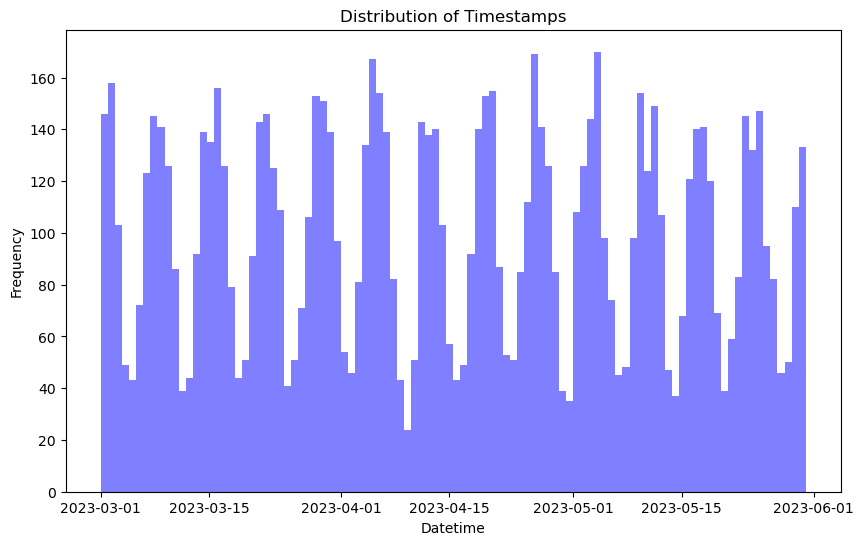

In [23]:
import matplotlib.pyplot as plt

def plot_timestamps(timestamps):
    plt.figure(figsize=(10,6))
    plt.hist(timestamps, bins=100, alpha=0.5, color='blue')
    plt.xlabel('Datetime')
    plt.ylabel('Frequency')
    plt.title('Distribution of Timestamps')
    plt.show()

timestamps = generate_timestamps()
timestamps_list = [t for t in timestamps]
# timestamps_list[0]

plot_timestamps(timestamps_list)

In [24]:

# WANDB LOGGING CONFIG
wandb_config = {"project": PROJECT, "entity":ENTITY}  # config for OpenAI autologger

table_cols = [
  "request_timestamp","request_id", "question", "question_id", "wandbot_answer", "retrived_source_documents",
  "answer_elapsed_time_s", "synth_grader_feedback", "grader_justification", # "eval_completion",
  "prompt_tokens", "completion_tokens", "total_tokens",
  "answer_cost_usd", "successful_requests", "answer_system_prompt_version",
  "eval_elapsed_time_s", "eval_cost_usd",  "eval_total_tokens", "eval_tokens_for_source_docs", "eval_prompt_tokens", "eval_completion_tokens", "is_source_documents_truncated",
  # "system_prompt_template", "human_message_prompt_template", "hyde_prompt_template", "eval_prompt_template",
  "wandb_run_id", "wandbot_model", "wandbot_temperature", "hyde_llm_temperature", 
  "eval_model", 
]

### Load Questions

In [ ]:
# import wandb
# # run = wandb.init()
# artifact = wandb.use_artifact('wandbot/wandbot_synth/run-g4rjeq92-logsqa_with_eval_final2:latest', type='run_table')
# df = artifact.get("logs/qa_with_eval_final2").get_dataframe()
# df

In [ ]:
artifact = wandb.use_artifact('wandbot/wandbot_synth/run-2cv1ao9n-generated_questions_table:v0', type='run_table')
# artifact_dir = artifact.download("data")
df = artifact.get("generated_questions_table").get_dataframe()
df["question_id"] = df.index

# SHUFFLE THE QUESTIONS
# np.random.shuffle(questions)
df = df.sample(frac=1).reset_index(drop=True)
print(len(df))

df.head()

wandb:   1 of 1 files downloaded.  


9670


,prompt,document,question,question_id
0,Let's start!\n Please generate ...,../docodile/docs/guides/artifacts/intro.md,Can one run use another run's output Artifact ...,3280
1,Let's start!\n Please generate ...,../docodile/docs/ref/cli/wandb-sync.md,How can you specify the project you want to up...,8227
2,Let's start!\n Please generate ...,../docodile/docs/ref/cli/wandb-login.md,What is the maximum number of authentication k...,8322
3,Let's start!\n Please generate ...,../docodile/docs/ref/cli/wandb-pull.md,Is Wandb Pull only used for downloading files ...,2683
4,Let's start!\n Please generate ...,../docodile/docs/guides/sweeps/visualize-sweep...,What kind of behavior can be altered in the Ed...,6993


### Setup Evaluation Model

Setup OpenAI Evaluator

In [26]:
eval_llm = ChatOpenAI(
    model_name=wandb.config.eval_model,
    temperature=wandb.config.openai_eval_llm_temperature,
    request_timeout=120
    )

eval_chain = LLMChain(llm=eval_llm, 
                      prompt=eval_prompt)

Get eval_prompt template token usage

In [27]:
# CALCUALTE THE EMPTY EVAL PROMPT TEAMPLATE TOKEN COUNT
openai_eval_prompt_template_txt = ""
for m in eval_prompt.messages:
    openai_eval_prompt_template_txt+=m.prompt.template

enc = tiktoken.encoding_for_model(wandb.config.eval_model)
eval_prompt_template_token_count = len(enc.encode(openai_eval_prompt_template_txt))
print(f"Eval prompt template token count: {eval_prompt_template_token_count}")

# REDUCE THE SOURCE DOCUMENTS TO FIT IN THE EVAL PROMPT
def check_and_shorten_openai_eval_source_docs(question, answer, source_documents, 
                                              eval_prompt_template_token_count=eval_prompt_template_token_count,
                                              max_eval_tokens=4096, completion_tokens=200):
    '''
    Sometimes the source docs are too long and we need to shorten them to fit in the eval prompt
    max_eval_tokens : context length of the eval model
    completion_tokens : if there is a need to reserve some tokens for the completion
    '''

    question_tokens = len(enc.encode(question))
    answer_tokens = len(enc.encode(answer))
    available_source_tokens = max_eval_tokens - (eval_prompt_template_token_count + question_tokens + answer_tokens) - completion_tokens

    if available_source_tokens < 0:
        source_documents = ""
        source_documents_truncated = True
        tokens_left_for_source_documents = 0
        return source_documents, source_documents_truncated, tokens_left_for_source_documents
    else:
        source_docs_token_ids = enc.encode(source_documents)
        source_docs_tokens = len(source_docs_token_ids)
    
        remaining_tokens = available_source_tokens - source_docs_tokens
        if remaining_tokens < 0:
            tokens_left_for_source_documents = available_source_tokens-10
            source_documents = enc.decode(source_docs_token_ids[:tokens_left_for_source_documents])
            source_documents_truncated = True
        else:
            source_documents_truncated = False
            tokens_left_for_source_documents = source_docs_tokens
        return source_documents, source_documents_truncated, tokens_left_for_source_documents

Eval prompt template token count: 701


In [28]:
question = "what is wandb?"
answer = "Weights & Biases is a machine learning platform for teams."
source_documents = "[hey, this is a document]"*100

_, source_documents_truncated, tokens_left_for_source_documents = check_and_shorten_openai_eval_source_docs(question, answer, source_documents)
source_documents_truncated, tokens_left_for_source_documents

(False, 701)

## Run Synth WandBot

Setup chain variants

In [30]:
chains = {}
for system_prompt in system_prompts.keys():
    chains[f"{system_prompt}"] = load_qa_chain(system_prompts[system_prompt], vector_store, chain_type="stuff")

chains.keys()

dict_keys(['wandbot_v1_few_shot', 'wandbot_v1_zero_shot', 'default_langchain_qa'])

In [35]:

import traceback
import langchain; 
langchain.debug=False

# for i_q, question in enumerate(questions):
# def answer_and_grade(i_q, questions, chains, timestamps):
def answer_and_grade(args):
    ii, question_id, question, chains, tstamp = args

    if (question == "") or (question is None):
        return

    # USER QUERY
    request_id = generate_id(length=16)
    
    # RUN CHAIN
    system_prompt = random.choice(list(chains.keys()))
    qa_chain = chains[system_prompt]

    try:
        start_time = time.time()
        with get_openai_callback() as openai_cb:
            response = qa_chain({"question": question}, 
                                callbacks=[WandbTracer(wandb_config)],
                                return_only_outputs=False,
                                )
        end_time = time.time()
        elapsed_time = end_time - start_time
        answer = response["answer"]

        # RETRIEVED DOCUMENTS
        source_docs = response["source_documents"]
        source_documents = parse_source_documents(source_docs)

        # TOKEN METRICS
        prompt_tokens = openai_cb.prompt_tokens
        completion_tokens = openai_cb.completion_tokens
        total_tokens = openai_cb.total_tokens
        total_cost = openai_cb.total_cost
        successful_requests = openai_cb.successful_requests

        # GENERATE SYNTHETIC USER FEEDBACK       
        try:     
            eval_source_documents, is_source_documents_truncated, eval_tokens_left_for_source_documents = check_and_shorten_openai_eval_source_docs(question, answer, source_documents)

            eval_start_time = time.time()
            with get_openai_callback() as openai_eval_cb:
                response = eval_chain({
                            "question": question, 
                            "answer": answer, 
                            "source_documents": eval_source_documents},
                            callbacks=[WandbTracer(wandb_config)],
                            )
                
            eval_end_time = time.time()
            eval_elapsed_time = eval_end_time - eval_start_time
            eval_completion = response["text"]

            # EVAL TOKEN METRICS
            eval_prompt_tokens = openai_eval_cb.prompt_tokens
            eval_completion_tokens = openai_eval_cb.completion_tokens
            eval_total_tokens = openai_eval_cb.total_tokens
            eval_cost = openai_eval_cb.total_cost
            eval_successful_requests = openai_eval_cb.successful_requests

            grader_justification = eval_completion.split("GRADE:")[0].strip()
            if "positive" in eval_completion.lower():
                grader_feedback = "POSITIVE"  
            elif "negative" in eval_completion.lower():
                grader_feedback = "NEGATIVE"
            else:
                grader_feedback = "GRADER_FAILURE"

        except Exception as eval_e:
            error_message = f"Question {question_id}, Eval Error occured: {eval_e}"
            print(error_message)

            eval_prompt_tokens = 0
            eval_completion_tokens = 0
            eval_total_tokens = 0
            eval_cost = 0
            eval_elapsed_time = 0
            eval_completion = "FAILURE"
            grader_feedback = "GRADER_FAILURE"
            grader_justification = error_message

            traceback.print_exc() 

        # LOG TO WANDB
        wandb_table = wandb.Table(table_cols)
        wandb_table.add_data(tstamp, request_id, question, question_id, answer, source_documents,
                            elapsed_time, grader_feedback, grader_justification, # eval_completion,
                            prompt_tokens, completion_tokens, total_tokens,
                            total_cost, successful_requests, system_prompt,
                            eval_elapsed_time, eval_cost, eval_total_tokens, eval_tokens_left_for_source_documents, eval_prompt_tokens, eval_completion_tokens, is_source_documents_truncated,
                            # system_prompts[system_prompt], human_message_prompt_template, hyde_prompt_template, openai_eval_prompt_template_txt,
                            wandb.run.id, wandb.config.model_name, wandb.config.temperature, wandb.config.hyde_llm_temperature, 
                            wandb.config.eval_model)
        wandb.log({"logs/qa_with_eval_final2": wandb_table})

    except Exception as e:
        print(f"Question {question_id}, Error occured: {e}")
        traceback.print_exc()
        
    if ii % 50 == 0: print(ii)

In [79]:
# config_table_cols = ["query_id","run_id",  "system_prompt_template", 
#                      "human_message_prompt_template", "hyde_prompt_template", "eval_grader_prompt_template"]
# config_table = wandb.Table(config_table_cols)  
# config_table.add_data(query_id, wandb.run.id, system_prompts[system_prompt], 
#                       human_message_prompt_template, hyde_prompt_template, eval_grader_prompt_template)
# wandb.log({"logs/config_table_test": config_table})

### Run logging in parellal

Set number of examples to run

In [36]:
n = len(df["question"].values.tolist()) #10000
qs = df["question"].values.tolist()[:n]
q_ids = df["question_id"].values.tolist()[:n]
ts = timestamps_list[:n]

n, len(qs), len(q_ids), len(ts)

Run in parallel

In [ ]:
import time
from fastcore.parallel import parallel

start = time.perf_counter()
parallel(answer_and_grade, list(zip(list(range(len(qs))), q_ids, qs, [chains]*len(qs), ts)), 
         n_workers=7, progress=True)  
end = time.perf_counter()

print(f'Time taken for {n} questions: {end - start} seconds, {(end - start)/n} seconds per question')

In [32]:
# res  = answer_and_grade((1, q_ids[0], qs[0], chains, ts[0]))

Log additional reference tables

In [ ]:
system_prompts_cols = ["run_id", "system_prompt_version", "system_prompt"]
system_prompts_table = wandb.Table(system_prompts_cols)  
for c in chains.keys():
    system_prompts_table.add_data(wandb.run.id, c, system_prompts[c])
wandb.log({"logs/answer_prompt_versions": system_prompts_table})

other_prompts_cols = ["run_id", "eval_grader_prompt_template", "human_message_prompt_template"]
other_prompts_table = wandb.Table(other_prompts_cols)  
for c in chains.keys():
    other_prompts_table.add_data(wandb.run.id, human_message_prompt_template, hyde_prompt_template, openai_eval_prompt_template_txt)
wandb.log({"logs/other_prompts": other_prompts_table})

In [ ]:
WandbTracer.finish()

In [ ]:
print("DONE!")

DONE!


# Archive
### Unused Prompts
Cohere Command Grader Prompt

In [ ]:
# human_prompt = "Human:"
# assistant_prompt = "GRADER_RESPONSE"

# grade_command = """Grade the following WANDBOT_RESPONSE given the USER_QUESTION and SUPPORTING_DOCUMENTATION. 
# Grade the WANDBOT_RESPONSE based ONLY on its factual accuracy. It is OK if the WANDBOT_RESPONSE contains more information than in SUPPORTING_DOCUMENTATION, as long as it does not contain any conflicting statements.
# Your GRADE should only be POSITIVE or NEGATIVE to indicate whether the WANDBOT_RESPONSE is accurate or not given the SUPPORTING_DOCUMENTATION.
# If the WANDBOT_RESPONSE is that there is no specific information provided in the context or that it doesn't know, then the GRADE is NEGATIVE.
# Be sure to read the SUPPORTING_DOCUMENTATION carefully before grading the WANDBOT_RESPONSE and be highlighly critical of WANDBOT_RESPONSE.
# Only respond with POSITIVE or NEGATIVE for GRADE. 
# In GRADE_JUSTIFICATION, explain why your GRADE of WANDBOT_RESPONSE is POSITIVE or NEGATIVE. Use one or two sentences maximum. Keep the answer as concise as possible."""


# def command_eval_prompt_constructor(question, source_documents, answer, grade_command=grade_command):
#     evaluation_prompts_template = f"""As an experienced software quality assurance tester, you are evaluating the quality of the response (WANDBOT_RESPONSE) from a
# Weights & Biasses (aka wandb, W&B) support bot called `wandbot`. Weights & Biasses is a machine learning ops (MLOps) python library and app.
# Supporting documentation (SUPPORTING_DOCUMENTATION) is provided to help you assess the quality of the response. You job is to grade (GRADE) the response.

# This is the example format of the input and a grade given to the `wandbot` support bot response:

# =====================
# USER_QUESTION: user question here
# WANDBOT_RESPONSE: the response from the `wandbot` support bot here
# SUPPORTING_DOCUMENTATION: retrieved documentation from the wandb docs here

# {assistant_prompt}
# GRADE_JUSTIFICATION: justification for the GRADE here
# GRADE: POSITIVE or NEGATIVE here
# =====================

# this is a real example:

# =====================
# USER_QUESTION: How do I create a wandb sweep?
# WANDBOT_RESPONSE: To create a W&B Articfact, you can use the wandb.Artifact class like so ```artifact = wandb.Artifact(name='bicycle-dataset', type='dataset')```
# SUPPORTING_DOCUMENTATION: '{{"source_doc_0": {{"page_content": "Use Weights & Biases Sweeps to automate hyperparameter search and explore the space of possible models. Create a sweep with a few lines of code.", "metadata": "https://docs.wandb.ai/guide", "lookup_index": 0, "lookup_str": ""}}}}'

# {assistant_prompt}
# GRADE_JUSTIFICATION: The USER_QUESTION was about how to create a wandb sweep, but the WANDBOT_RESPONSE answers how to create a wandb artifact. The WANDBOT_RESPONSE is not accurate.
# GRADE: NEGATIVE
# =====================

# {grade_command}

# =====================
# USER_QUESTION: {question}
# WANDBOT_RESPONSE: {answer}
# SUPPORTING_DOCUMENTATION: {source_documents}

# {assistant_prompt}
# GRADE_JUSTIFICATION:"""
#     return evaluation_prompts_template

# question = "what is wandb?"
# answer = "Weights & Biases is a machine learning platform for teams."
# source_documents = "[hey, this is a document]"
# print(command_eval_prompt_constructor(question, source_documents, answer, grade_command))

Cohere Command prompt template

In [ ]:
# from tokenizers import Tokenizer

# eval_grader_prompt_template = command_eval_prompt_constructor("", "", "")

# command_nightly_tokenizer = Tokenizer.from_pretrained("Cohere/command-nightly")
# prompt_enc = command_nightly_tokenizer.encode(eval_grader_prompt_template)
# print(f"Command prompt template token count: {len(prompt_enc.ids)}, character count: {len(eval_grader_prompt_template)}")

Claude Grader Prompt

In [ ]:
# def claude_eval_prompt_constructor(question, source_documents, answer):
#     evaluation_prompts_template = f"""As an experienced software quality assurance tester, you are evaluating the quality of the response from a
#     Weights & Biasses (aka wandb, W&B) support bot called wandbot. Weights & Biasses is a machine learning ops (MLOps) python library and app.
#     Supporting documentation is provided to help you assess the quality of the response.
#     Your feedback should only only be "POSITIVE" or "NEGATIVE" to indicate whether the response is accurate or not,
#     no other information is required. For example:
#     {anthropic.HUMAN_PROMPT}
#     =====================
#     USER_QUESTION: What is wandb?
#     SUPPORTING_DOCUMENTATION: '{{"source_doc_0": {{"page_content": "Weights & Biases is the machine learning platform for developers to build better models faster", "metadata": "https://docs.wandb.ai/guide", "lookup_index": 0, "lookup_str": ""}}}}'
#     WANDBOT_RESPONSE: Weights & Biases is a machine learning platform for teams.
#     {anthropic.AI_PROMPT}
#     POSITIVE
#     {anthropic.HUMAN_PROMPT}
#     =====================
#     USER_QUESTION: How do I create a wandb sweep?
#     SUPPORTING_DOCUMENTATION: '{{"source_doc_0": {{"page_content": "Use Weights & Biases Sweeps to automate hyperparameter search and explore the space of possible models. Create a sweep with a few lines of code.", "metadata": "https://docs.wandb.ai/guide", "lookup_index": 0, "lookup_str": ""}}}}'
#     WANDBOT_RESPONSE: To create a W&B Articfact, you can use the wandb.Artifact class like so ```artifact = wandb.Artifact(name='bicycle-dataset', type='dataset')```
#     {anthropic.AI_PROMPT}
#     NEGATIVE
#     {anthropic.HUMAN_PROMPT}
#     =====================
#     USER_QUESTION: {question}
#     SUPPORTING_DOCUMENTATION: {source_documents}
#     WANDBOT_RESPONSE: {answer}
#     {anthropic.AI_PROMPT}"""
#     return evaluation_prompts_template

# question = "what is wandb?"
# answer = "Weights & Biases is a machine learning platform for teams."
# print(claude_eval_prompt_constructor(question, source_documents, answer))

Setup Cohere Evaluator

In [ ]:
# import cohere

# def calculate_eval_tokens(eval_grader_prompt, eval_completion):
#     prompt_enc = command_nightly_tokenizer.encode(eval_grader_prompt)
#     prompt_tokens_count = len(prompt_enc.ids)
#     completion_enc = command_nightly_tokenizer.encode(eval_completion)
#     completion_token_count = len(completion_enc.ids)
#     completion_total_tokens = prompt_tokens_count + completion_token_count
#     return completion_total_tokens, prompt_tokens_count, completion_token_count


# def check_and_shorten_eval_source_docs(question, answer, source_documents, grade_command, max_eval_tokens=4096):
#     '''
#     Sometimes the source docs are too long and we need to shorten them to fit in the eval prompt
#     '''
#     dummy_eval_prompt = command_eval_prompt_constructor(question, "", answer, grade_command)

#     dummy_eval_prompt_enc = command_nightly_tokenizer.encode(dummy_eval_prompt)
#     available_eval_tokens = max_eval_tokens - len(dummy_eval_prompt_enc.ids) 

#     source_docs_enc = command_nightly_tokenizer.encode(source_documents)
#     source_docs_tokens = len(source_docs_enc.ids) 

#     remainder_eval_tokens = available_eval_tokens - source_docs_tokens
#     if remainder_eval_tokens < 0:
#         source_documents = command_nightly_tokenizer.decode(source_docs_enc.ids[:available_eval_tokens-50])
#         is_source_documents_truncated = True
#     else: is_source_documents_truncated = False

#     return source_documents, is_source_documents_truncated

# co = cohere.Client(cohere_api_key)


Anthropic Evaluation

In [ ]:
# # ANTHROPIC EVALUATION
# eval_model = "claude-v1.3-100k" # "claude-v1",
# # anthropic_api = "XXX"
# # client = anthropic.Client(api_key=anthropic_api)
# # max_tokens_to_sample = 100000

# eval_prompt_template = claude_eval_prompt_constructor("", "", "")  # Just to log the eval prompt template
# # eval_prompt = claude_eval_prompt_constructor(question, source_documents, answer)

# eval_start_time = time.time()
# # resp = client.completion(
# #     prompt=eval_prompt,
# #     stop_sequences=[anthropic.HUMAN_PROMPT],
# #     model=eval_model,
# #     max_tokens_to_sample=max_tokens_to_sample,
# # )